In [1]:
## data manipulation 
import numpy as np
import pandas as pd

## plotting
import matplotlib.pyplot as plt
import seaborn as sns

## nueral network creation
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout ,GlobalAveragePooling2D
from keras.models import Sequential,Model ##  sequential model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

## pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Evalution metrics
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

import os, shutil
import warnings
warnings.filterwarnings('ignore')

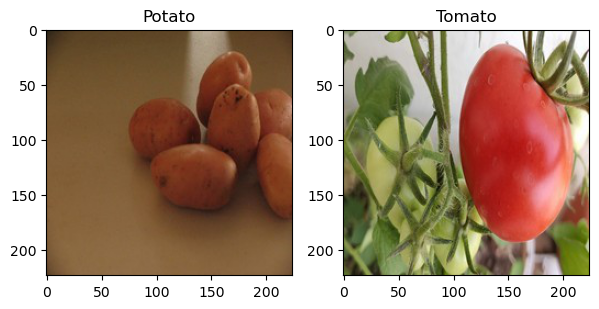

In [2]:
# data paths 定义数据路径,分别用于存放训练数据、验证数据和测试数据。
train_path = "train/"
validation_path = "validation/"
test_path = "test/"
# 读取文件和文件夹名
image_categories = os.listdir('train/')

def plot_images(image_categories):
    '''
     Plot Each label Once
    '''
    # Create a figure
    plt.figure(1,figsize=(15, 10))
    for i, cat in enumerate(image_categories):          #遍历这些类别标签，加载每个类别中的第一张图片，

        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[i]    # 将其转换为适合绘图的数组格式
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255
        # Create Subplot and plot the images      使用matplotlib库创建一个图表，并在图表中为每个类别绘制一个子图，显示该类别的第一张图片
        plt.subplot(3, 5, i+1)
        plt.title(cat)
        plt.imshow(img_arr)

    plt.tight_layout()

plot_images(image_categories)

<Axes: >

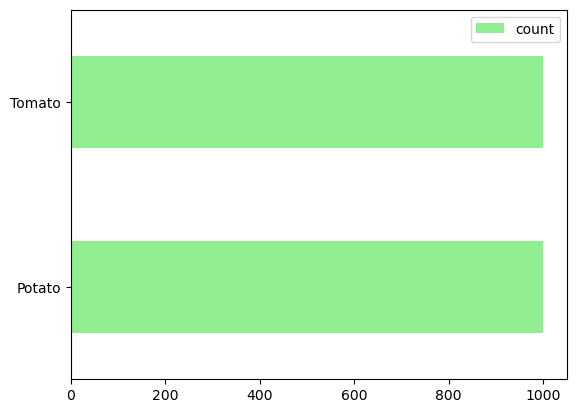

In [3]:
# IS Dataset Balanced

images_length={}
for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        images_length[cat]=len(images_in_folder)
        
pd.DataFrame(images_length,index = ['count']).T.plot(kind='barh',color='lightgreen')

In [ ]:
''' Data Augmentation: is a process to increase training set generating new data points from existing Data. Prevents Overfitting
    Only applicable at Training Phase.
'''
# 数据增强：一个过程，通过从现有数据中生成新的数据点来增加训练集。这有助于防止过拟合。
# 该过程仅在训练阶段适用。

# 打印训练数据的信息
print("Train Data: ",end=' ')
# 创建一个ImageDataGenerator对象，用于训练数据的增强
train_gen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalise the data 将数据归一化到0-1范围
    shear_range=0.2,  # 随机剪切强度（逆时针方向）
    zoom_range=0.2,  # 随机缩放范围（1±zoom_range）
    horizontal_flip=True,
)  # 随机水平翻转

# 使用ImageDataGenerator的flow_from_directory方法从目录中读取训练数据
train_image_generator = train_gen.flow_from_directory(
    train_path,  # 训练数据所在目录的路径
    target_size=(224, 224),  # 所有的图片将被调整到这个大小
    batch_size=64,  # 每次从目录中读取的图片数量
    class_mode="categorical",  # 因为是多分类问题，所以返回的是one-hot编码的标签
)


# 打印验证数据的信息
print("Validation Data: ",end=' ')
# 创建一个ImageDataGenerator对象，仅用于验证数据的归一化（不进行增强）
val_gen = ImageDataGenerator(rescale=1./255) 
val_image_generator = val_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(224, 224),
                                            batch_size=64,
                                            class_mode='categorical',
                                            )
# 打印测试数据的信息（注意：这里通常不需要进行数据增强，因为测试集用于评估模型在未见过的数据上的性能）
print("Test Data: ",end=' ')
# 创建一个ImageDataGenerator对象，仅用于测试数据的归一化（不进行增强）

test_gen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_gen.flow_from_directory(
    test_path,  # 测试数据所在目录的路径
    target_size=(224, 224),
    batch_size=64,  # 这里的batch_size在测试时可能并不重要，因为通常会一次性处理整个测试集
    class_mode="categorical",
    shuffle=False,  # 测试时不应该打乱数据顺序
)

Train Data:  Found 2000 images belonging to 2 classes.
Validation Data:  Found 400 images belonging to 2 classes.
Test Data:  Found 400 images belonging to 2 classes.


In [ ]:
''' encoding labels '''    #“编码标签”
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])    #即将整数索引映射回原始的类别标签（目录名）。
print(class_map)

{0: 'Potato', 1: 'Tomato'}


In [ ]:
'''
LeNet Model Architecture
'''
# Building the Model Architecture
model_le = Sequential()  #初始化了一个Sequential模型。Sequential是Keras中用于线性堆叠层的模型，这意味着每个层有一个单一的输入张量和一个单一的输出张量。


model_le.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(224, 224, 3)))
model_le.add(MaxPooling2D(pool_size=(2, 2)))

model_le.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model_le.add(MaxPooling2D(pool_size=(2, 2)))

model_le.add(Flatten())
model_le.add(Dense(1024, activation='relu'))
model_le.add(Dense(128, activation='relu'))
model_le.add(Dense(2, activation='softmax'))

model_le.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      51232     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 89888)             0         
                                                                 
 dense (Dense)               (None, 1024)              9

In [ ]:
# Compile and fit the model
''' 
 Early Stopping : is a regularization technique which is used to prevent overfitting and improve generalization performance.
 The Basic Idea is that to monitor the model's performance on validation data , if performances are not improving 
 '''
early_stopping = keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',restore_best_weights=True) # Set up callbacks


model_le.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')
hist = model_le.fit(train_image_generator, 
                 epochs=10, 
                 verbose=1, 
                 validation_data=val_image_generator, 
                 steps_per_epoch = 2000//64, 
                 validation_steps = 400//64, 
                 callbacks=early_stopping,
                 workers=8
                )

Epoch 1/10
31/31 [==============================] - 182s 6s/step - loss: 0.6445 - accuracy: 0.7154 - val_loss: 0.3448 - val_accuracy: 0.8516
Epoch 2/10
31/31 [==============================] - 183s 6s/step - loss: 0.2770 - accuracy: 0.8951 - val_loss: 0.1840 - val_accuracy: 0.9089
Epoch 3/10
31/31 [==============================] - 179s 6s/step - loss: 0.1298 - accuracy: 0.9607 - val_loss: 0.0730 - val_accuracy: 0.9766
Epoch 4/10
31/31 [==============================] - 181s 6s/step - loss: 0.1047 - accuracy: 0.9638 - val_loss: 0.0511 - val_accuracy: 0.9766
Epoch 5/10
31/31 [==============================] - 174s 6s/step - loss: 0.0480 - accuracy: 0.9923 - val_loss: 0.0367 - val_accuracy: 0.9896
Epoch 6/10
31/31 [==============================] - 177s 6s/step - loss: 0.0348 - accuracy: 0.9928 - val_loss: 0.0465 - val_accuracy: 0.9922
Epoch 7/10
31/31 [==============================] - 171s 5s/step - loss: 0.0559 - accuracy: 0.9814 - val_loss: 0.0261 - val_accuracy: 0.9974
Epoch 8/10
17

In [ ]:
# model_le.save("my_model.h5")

In [ ]:
# 保存模型权重
model_le.save_weights("lenet_weights.h5")

In [ ]:
# 导入必要的库
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# 定义模型结构（确保与保存权重时的结构相同）
model_le = Sequential()
# model_le.add(
#     Conv2D(64, kernel_size=(5, 5), activation="relu", input_shape=(224, 224, 3))
# )
# model_le.add(MaxPooling2D(pool_size=(2, 2)))
# ... 其他层 ...
# model_le.add(Dense(2, activation="softmax"))
model_le.add(
    Conv2D(64, kernel_size=(5, 5), activation="relu", input_shape=(224, 224, 3))
)
model_le.add(MaxPooling2D(pool_size=(2, 2)))

model_le.add(Conv2D(32, kernel_size=(5, 5), activation="relu"))
model_le.add(MaxPooling2D(pool_size=(2, 2)))

model_le.add(Flatten())
model_le.add(Dense(1024, activation="relu"))
model_le.add(Dense(128, activation="relu"))
model_le.add(Dense(2, activation="softmax"))

# 加载模型权重
model_le.load_weights("lenet_weights.h5")
# 编译模型（确保与保存权重时的编译参数相同）
model_le.compile(loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])
    


# 现在你可以使用加载了权重的模型进行预测或评估等操作

In [ ]:
# model_le.save("model_le.h5")  # 这将保存模型的结构、权重和优化器的状态

In [ ]:
def plot_accuracy(history):
    '''
         plot accuracy vs validation accuracy
    '''
    plt.plot(history.history['accuracy'],label='train accuracy',color='blue')
    plt.plot(history.history['val_accuracy'],label='validation accuracy',color='blue',linestyle='dashed')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()
    
def plot_loss(history):
    '''
     plot loss vs validation loss
    '''
    plt.plot(history.history['loss'],label="train loss",color='red')
    plt.plot(history.history['val_loss'],label="validation loss",color='red',linestyle='dashed')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

## helper function to get accuracy of the model
def eval_(model):
    '''
     Model Evaluation
    '''
    plt.figure(figsize=(20, 15))
    test_loss, test_acc =model.evaluate(test_image_generator)
    print(f'Model Test loss : {np.round(test_loss,2)} and Test Accuracy : {np.round(test_acc,2)} ')
    
    y_pred = model.predict(test_image_generator)
    predicted_classes = np.argmax(y_pred,axis=1)
    print("\n------- Classification Report -------\n",classification_report(test_image_generator.classes,predicted_classes))
    
    # Confusion Matrix dispaly
    ConfusionMatrixDisplay(confusion_matrix(test_image_generator.classes,predicted_classes),display_labels = test_image_generator.class_indices.keys()).plot()
    plt.show()

In [ ]:
plot_loss(hist)
plot_accuracy(hist)

NameError: name 'hist' is not defined

7/7 [==============================] - 8s 978ms/step - loss: 0.0062 - accuracy: 0.9975
Model Test loss : 0.01 and Test Accuracy : 1.0 
7/7 [==============================] - 6s 789ms/step

------- Classification Report -------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      0.99      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



<Figure size 2000x1500 with 0 Axes>

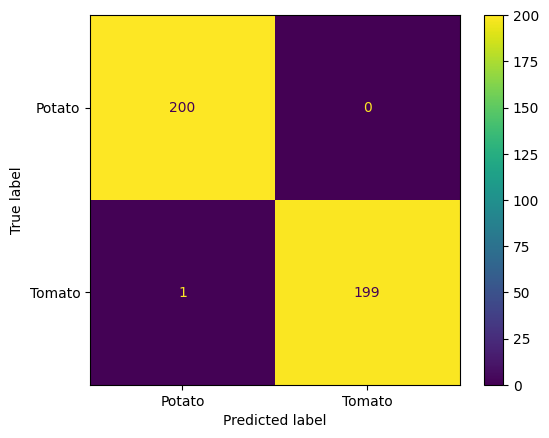

In [ ]:
eval_(model_le)

In [ ]:
'''
1. Create base model using api
2. use imagent weights (or) else
3. Remove fully connected layers after removing now base model acts as a powerful feature extractor.
'''
# 1. 使用API创建基础模型
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=[224,224,3])
# 2. 使用ImageNet权重（这一步在创建base_model时已经做了）
# 注意：'imagenet' 权重是自动下载的，所以确保网络连接正常

# Frezzing all the layers which prevents the weights being updated
# 3. 冻结所有层以防止权重更新
for layer in base_model.layers:
    layer.trainable = False

## Add new layers to the Model
# 添加新层到模型中
# 使用base_model的输出作为新层的输入
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 添加全局平均池化层
x = Dense(128, activation="relu")(x)  # 添加全连接层，128个神经元，ReLU激活
x = Dropout(0.2)(x)  # 添加Dropout层，防止过拟合
prediction = Dense(2, activation='softmax')(x)
# 最终的输出层，2个神经元，Softmax激活（假设是二分类问题）


# 创建一个新模型，输入是base_model的输入，输出是prediction
model_V3 = Model(inputs=base_model.input, outputs=prediction)
# 设置早停回调函数
early_stopping = keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',restore_best_weights=True,min_delta=0.1)

## compile the model
# 编译模型
model_V3.compile(
    loss="categorical_crossentropy",  #使用分类交叉熵损失，适用于多分类问题（即使是二分类）
    optimizer="adam",  #使用Adam优化器
    metrics=["accuracy"],  #监控准确度指标
)

##fit the model
# 拟合模型
# 注意：train_image_generator和val_image_generator应该是ImageDataGenerator的实例，它们已经设置了数据增强和批次大小等参数
# steps_per_epoch和validation_steps应该根据你的批次大小和数据集大小来计算
hist = model_V3.fit(
    train_image_generator,  # 这里假设train_image_generator知道总步数，通常设置为总样本数除以批次大小
    epochs=10,
    verbose=1,
    validation_data=val_image_generator,  # 这里假设val_image_generator知道总步数，通常设置为验证集样本数除以批次大小
    steps_per_epoch=len(train_image_generator),
    validation_steps=len(val_image_generator),
    callbacks=early_stopping,  # callbacks应该是一个列表
    workers=8,  # 使用多线程来加速数据加载和处理
)


Epoch 1/10
32/32 [==============================] - 81s 2s/step - loss: 0.0645 - accuracy: 0.9715 - val_loss: 0.0106 - val_accuracy: 0.9950
Epoch 2/10
32/32 [==============================] - 71s 2s/step - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 3/10
32/32 [==============================] - 69s 2s/step - loss: 0.0036 - accuracy: 0.9985 - val_loss: 0.0049 - val_accuracy: 0.9975
Epoch 4/10
32/32 [==============================] - 75s 2s/step - loss: 0.0031 - accuracy: 0.9985 - val_loss: 0.0113 - val_accuracy: 0.9950


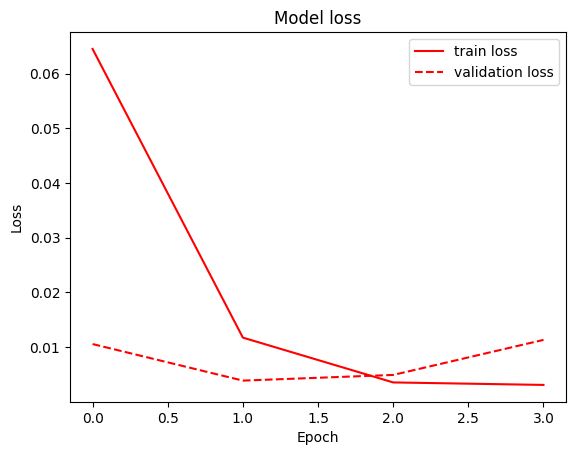

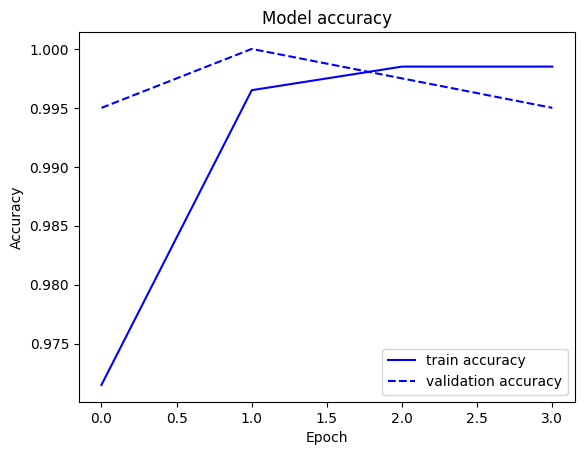

In [ ]:
plot_loss(hist)
plot_accuracy(hist)

7/7 [==============================] - 12s 2s/step - loss: 6.0080e-04 - accuracy: 1.0000
Model Test loss : 0.0 and Test Accuracy : 1.0 
7/7 [==============================] - 13s 2s/step

------- Classification Report -------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



<Figure size 2000x1500 with 0 Axes>

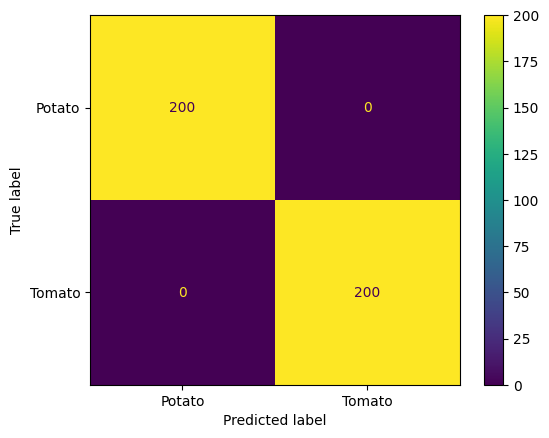

In [ ]:
eval_(model_V3)

In [ ]:

model_V3.save("model_V3.h5")

In [ ]:
from tensorflow.keras.models import load_model




# 假设你已经有一个名为'model_V3.h5'的模型文件
model_V3 = load_model("model_V3.h5")
model_V3.decode("utf-8", "ignore")
print(model_V3)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfd in position 12: invalid start byte

In [ ]:
## Freeze A Few layers
# 加载预训练的InceptionV3模型，不包括顶部的全连接层，输入形状为(224, 224, 3)
base_model = InceptionV3(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)

# Frezzing all the layers which prevents the waits being updated
# 冻结所有层，防止它们的权重在训练时被更新
for layer in base_model.layers:
    layer.trainable = False

# unFrezzing last few layers
# 解冻最后10层（不考虑它们是否是卷积块或全连接层
for layer in base_model.layers[-10:]:
    layer.trainable = True

## Add new layers to the Model
# 向模型添加新的层
x = base_model.output
x = GlobalAveragePooling2D()(x)  #全局平均池化层
x = Dense(128, activation="relu")(x)  #全连接层，128个神经元，ReLU激活函数
x = Dropout(0.2)(x)  #Dropout层，防止过拟合
prediction = Dense(2, activation="softmax")(x)  #输出层，2个神经元（类别），softmax激活函数

# 创建新的模型，输入为base_model的输入，输出为prediction
model_v = Model(inputs=base_model.input, outputs=prediction)
# 设置早期停止回调，当验证损失在连续2个epoch内没有改善时停止训练，并恢复最佳权重
early_stopping = keras.callbacks.EarlyStopping(
    patience=2, monitor="val_loss", restore_best_weights=True
)  # Set up callbacks

## compile the model
# 编译模型，使用Adam优化器，学习率为1e-4，损失函数为分类交叉熵，评估指标为准确率
model_v.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics="accuracy",
)

##fit the model
# 训练模型，使用数据生成器进行训练和验证，每个epoch有2000//64步，验证有400//64步
# 注意：这里的步骤数应该基于你的数据集大小和批次大小来计算
hist = model_v.fit(
    train_image_generator,  # 假设这是你的训练数据生成器
    epochs=10,
    verbose=1,
    validation_data=val_image_generator,  # 假设这是你的验证数据生成器
    steps_per_epoch=2000 // 64,  # 每个epoch的步数
    validation_steps=400 // 64,  # 验证的步数
    callbacks=early_stopping,  # callbacks应该是一个列表
    workers=8,  # 使用8个工作线程进行数据处理
)

Epoch 1/10
31/31 [==============================] - 75s 2s/step - loss: 0.2874 - accuracy: 0.8895 - val_loss: 0.0461 - val_accuracy: 0.9896
Epoch 2/10
31/31 [==============================] - 74s 2s/step - loss: 0.0541 - accuracy: 0.9871 - val_loss: 0.0226 - val_accuracy: 0.9948
Epoch 3/10
31/31 [==============================] - 74s 2s/step - loss: 0.0294 - accuracy: 0.9948 - val_loss: 0.0160 - val_accuracy: 0.9948
Epoch 4/10
31/31 [==============================] - 73s 2s/step - loss: 0.0233 - accuracy: 0.9948 - val_loss: 0.0159 - val_accuracy: 0.9948
Epoch 5/10
31/31 [==============================] - 74s 2s/step - loss: 0.0201 - accuracy: 0.9964 - val_loss: 0.0121 - val_accuracy: 0.9948
Epoch 6/10
31/31 [==============================] - 84s 3s/step - loss: 0.0123 - accuracy: 0.9974 - val_loss: 0.0080 - val_accuracy: 0.9948
Epoch 7/10
31/31 [==============================] - 79s 3s/step - loss: 0.0112 - accuracy: 0.9979 - val_loss: 0.0068 - val_accuracy: 0.9974
Epoch 8/10
31/31 [==

In [ ]:
# 保存模型权重
# model_v.save_weights("lenet_weights333.h5")

In [ ]:
model_v.save("lenet333.h5")

NameError: name 'model_v' is not defined

In [ ]:
# 导入必要的库
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# 定义模型结构（确保与保存权重时的结构相同）
# model_le = Sequential()
# model_le.add(
#     Conv2D(64, kernel_size=(5, 5), activation="relu", input_shape=(224, 224, 3))
# )
# model_le.add(MaxPooling2D(pool_size=(2, 2)))
# ... 其他层 ...
# model_le.add(Dense(2, activation="softmax"))
# model_le.add(
#     Conv2D(64, kernel_size=(5, 5), activation="relu", input_shape=(224, 224, 3))
# )
# model_le.add(MaxPooling2D(pool_size=(2, 2)))

# model_le.add(Conv2D(32, kernel_size=(5, 5), activation="relu"))
# model_le.add(MaxPooling2D(pool_size=(2, 2)))

# model_le.add(Flatten())
# model_le.add(Dense(1024, activation="relu"))
# model_le.add(Dense(128, activation="relu"))
# model_le.add(Dense(2, activation="softmax"))

# 加载模型权重
# model_v.load_weights("lenet_weights333.h5")
model_v.load("lenet333.h5")
# 编译模型（确保与保存权重时的编译参数相同）
# model_le.compile(
#     loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
# )

AttributeError: 'Functional' object has no attribute 'load'

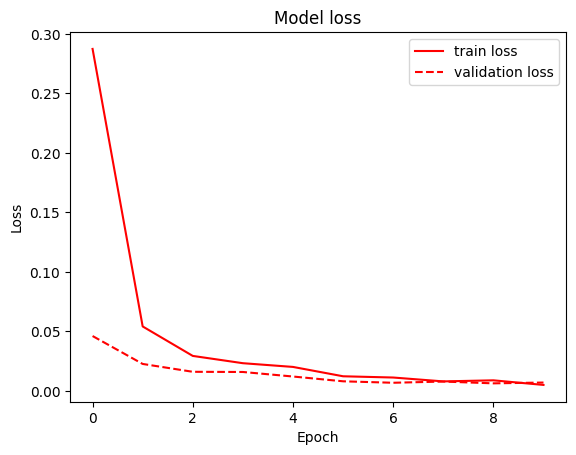

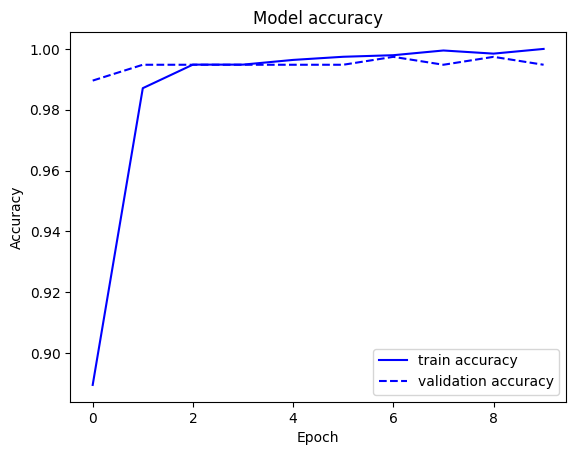

In [ ]:
plot_loss(hist)
plot_accuracy(hist)

7/7 [==============================] - 10s 1s/step - loss: 0.8554 - accuracy: 0.3925
Model Test loss : 0.86 and Test Accuracy : 0.39 
7/7 [==============================] - 12s 2s/step

------- Classification Report -------
               precision    recall  f1-score   support

           0       0.36      0.29      0.32       200
           1       0.41      0.49      0.45       200

    accuracy                           0.39       400
   macro avg       0.39      0.39      0.39       400
weighted avg       0.39      0.39      0.39       400



<Figure size 2000x1500 with 0 Axes>

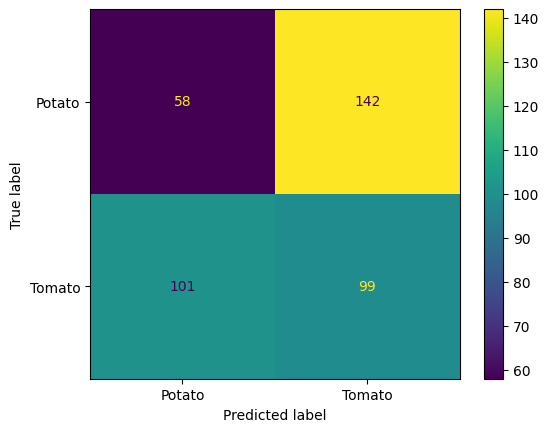

In [ ]:
eval_(model_v)

In [1]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import load_model

# 假设model_v是预先训练好的模型，class_map是类别映射字典
# model_v, class_map = ... （这两个变量需要您提前定义好）
model_V3 = load_model("model_V3.h5")
print(model_V3)

def predict(image_path):
    # 定义类别映射字典
    class_map = {0: 'Potato', 1: 'Tomato'}

    # 检查图像文件是否存在且路径合法
    if not os.path.isfile(image_path):
        print("Image file does not exist. Please provide a valid path.")
        return

    # 加载并预处理图像
    img_ = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.0  # 标准化图像数据

    # 预测
    prediction = model_V3.predict(img_processed)
    index = np.argmax(prediction)  # 获取预测的类别索引
    confidence = prediction[0][index]  # 获取预测的置信度

    # 获取预测的类别名称
    predicted_class = class_map.get(index, "Unknown")

    # 返回预测类别名称和置信度
    return predicted_class, confidence


# 示例调用
result_class, result_confidence = predict("image.png")
print(f"Predicted Class: {result_class}, Confidence: {result_confidence}")


1/1 [==============================] - 1s 1s/step
Predicted Class: Tomato, Confidence: 0.9777758717536926


In [ ]:
predict("o.png")

Image file does not exist. Please provide a valid path.


1/1 [==============================] - 2s 2s/step


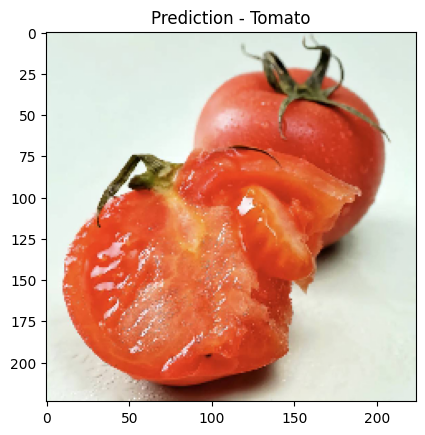

'Tomato'

In [ ]:
predict("tomato.jpg")

1/1 [==============================] - 0s 55ms/step


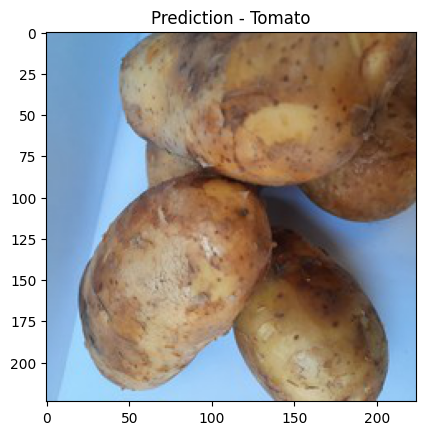

In [ ]:
def predict(label, image_number):

    if label not in class_map.values() or image_number >= 1000:
        print(
            "Wrong Input 1. check if label in those 15 classes 2. image_number must be less than 1000"
        )
    image_path = train_path + "/" + label
    images_in_folder = os.listdir(image_path)
    first_image_of_folder = images_in_folder[image_number]
    image_path += "/" + first_image_of_folder

    img_ = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.0

    prediction = model_v.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(class_map[index]))
    plt.imshow(img_array)


predict("Potato", 1)
# predict("Tomato", 19)

1/1 [==============================] - 0s 68ms/step


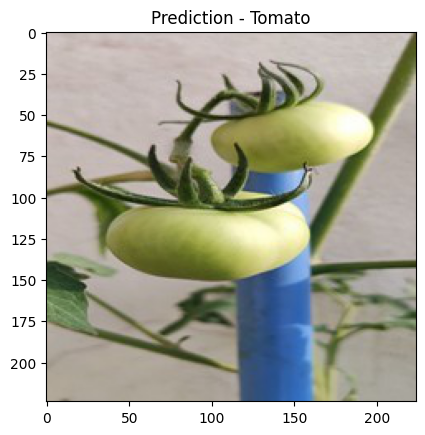

In [ ]:
predict("Tomato", 2)

Wrong Input 1. check if label in those 15 classes 2. image_number must be less than 1000
1/1 [==============================] - 0s 74ms/step


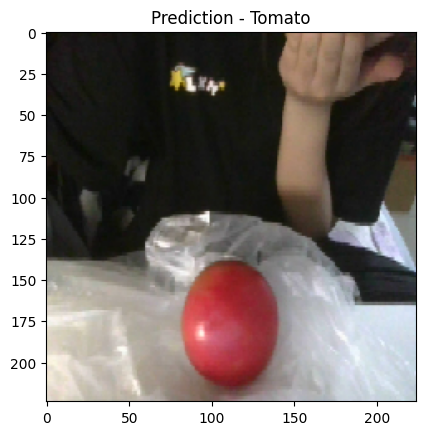

In [ ]:
predict("Tomato",1000 )